<a href="https://colab.research.google.com/github/ritwiks9635/My_Neural_Network_Architecture/blob/main/Teach_StableDiffusion_new_concepts_via_Textual_Inversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#****Teach StableDiffusion new concepts via Textual Inversion****

## Textual Inversion

Since its release, StableDiffusion has quickly become a favorite amongst
the generative machine learning community.
The high volume of traffic has led to open source contributed improvements,
heavy prompt engineering, and even the invention of novel algorithms.

Perhaps the most impressive new algorithm being used is
[Textual Inversion](https://github.com/rinongal/textual_inversion), presented in
[_An Image is Worth One Word: Personalizing Text-to-Image Generation using Textual Inversion_](https://textual-inversion.github.io/).

Textual Inversion is the process of teaching an image generator a specific visual concept
through the use of fine-tuning. In the diagram below, you can see an
example of this process where the authors teach the model new concepts, calling them
"S_*".

![https://i.imgur.com/KqEeBsM.jpg](https://i.imgur.com/KqEeBsM.jpg)

Conceptually, textual inversion works by learning a token embedding for a new text
token, keeping the remaining components of StableDiffusion frozen.

This guide shows you how to fine-tune the StableDiffusion model shipped in KerasCV
using the Textual-Inversion algorithm.  By the end of the guide, you will be able to
write the "Gandalf the Gray as a &lt;my-funny-cat-token&gt;".

![https://i.imgur.com/rcb1Yfx.png](https://i.imgur.com/rcb1Yfx.png)


First, let's import the packages we need, and create a
StableDiffusion instance so we can use some of its subcomponents for fine-tuning.

In [ ]:
!pip install -q git+https://github.com/keras-team/keras-cv.git
#!pip install -q tensorflow==2.11.0

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 4.9 MB/s eta 0:00:00


In [ ]:
import math

import keras_cv
import numpy as np
import tensorflow as tf
from keras_cv import layers as cv_layers
from keras_cv.models.stable_diffusion import NoiseScheduler
from tensorflow import keras
import matplotlib.pyplot as plt

stable_diffusion = keras_cv.models.StableDiffusion()

Using TensorFlow backend
By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


Next, let's define a visualization utility to show off the generated images:

In [ ]:
def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

## Assembling a text-image pair dataset

In order to train the embedding of our new token, we first must assemble a dataset
consisting of text-image pairs.
Each sample from the dataset must contain an image of the concept we are teaching
StableDiffusion, as well as a caption accurately representing the content of the image.
In this tutorial, we will teach StableDiffusion the concept of Luke and Ian's GitHub
avatars:

![gh-avatars](https://i.imgur.com/WyEHDIR.jpg)

First, let's construct an image dataset of cat dolls:

In [ ]:
def assemble_image_dataset(urls):
    # Fetch all remote files
    files = [tf.keras.utils.get_file(origin=url) for url in urls]

    # Resize images
    resize = keras.layers.Resizing(height=512, width=512, crop_to_aspect_ratio=True)
    images = [keras.utils.load_img(img) for img in files]
    images = [keras.utils.img_to_array(img) for img in images]
    images = np.array([resize(img) for img in images])

    # The StableDiffusion image encoder requires images to be normalized to the
    # [-1, 1] pixel value range
    images = images / 127.5 - 1

    # Create the tf.data.Dataset
    image_dataset = tf.data.Dataset.from_tensor_slices(images)

    # Shuffle and introduce random noise
    image_dataset = image_dataset.shuffle(50, reshuffle_each_iteration=True)
    image_dataset = image_dataset.map(
        cv_layers.RandomCropAndResize(
            target_size=(512, 512),
            crop_area_factor=(0.8, 1.0),
            aspect_ratio_factor=(1.0, 1.0),
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    image_dataset = image_dataset.map(
        cv_layers.RandomFlip(mode="horizontal"),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    return image_dataset

Next, we assemble a text dataset:

In [ ]:
MAX_PROMPT_LENGTH = 77
placeholder_token = "<my-funny-cat-token>"


def pad_embedding(embedding):
    return embedding + (
        [stable_diffusion.tokenizer.end_of_text] * (MAX_PROMPT_LENGTH - len(embedding))
    )


stable_diffusion.tokenizer.add_tokens(placeholder_token)


def assemble_text_dataset(prompts):
    prompts = [prompt.format(placeholder_token) for prompt in prompts]
    embeddings = [stable_diffusion.tokenizer.encode(prompt) for prompt in prompts]
    embeddings = [np.array(pad_embedding(embedding)) for embedding in embeddings]
    text_dataset = tf.data.Dataset.from_tensor_slices(embeddings)
    text_dataset = text_dataset.shuffle(100, reshuffle_each_iteration=True)
    return text_dataset

1356917/1356917 [==============================] - 0s 0us/step


Finally, we zip our datasets together to produce a text-image pair dataset.

In [ ]:
def assemble_dataset(urls, prompts):
    image_dataset = assemble_image_dataset(urls)
    text_dataset = assemble_text_dataset(prompts)
    # the image dataset is quite short, so we repeat it to match the length of the
    # text prompt dataset
    image_dataset = image_dataset.repeat()
    # we use the text prompt dataset to determine the length of the dataset.  Due to
    # the fact that there are relatively few prompts we repeat the dataset 5 times.
    # we have found that this anecdotally improves results.
    text_dataset = text_dataset.repeat(5)
    return tf.data.Dataset.zip((image_dataset, text_dataset))

In order to ensure our prompts are descriptive, we use extremely generic prompts.

Let's try this out with some sample images and prompts.

In [ ]:
train_ds = assemble_dataset(
    urls=[
        "https://i.imgur.com/VIedH1X.jpg",
        "https://i.imgur.com/eBw13hE.png",
        "https://i.imgur.com/oJ3rSg7.png",
        "https://i.imgur.com/5mCL6Df.jpg",
        "https://i.imgur.com/4Q6WWyI.jpg",
    ],
    prompts=[
        "a photo of a {}",
        "a rendering of a {}",
        "a cropped photo of the {}",
        "the photo of a {}",
        "a photo of a clean {}",
        "a dark photo of the {}",
        "a photo of my {}",
        "a photo of the cool {}",
        "a close-up photo of a {}",
        "a bright photo of the {}",
        "a cropped photo of a {}",
        "a photo of the {}",
        "a good photo of the {}",
        "a photo of one {}",
        "a close-up photo of the {}",
        "a rendition of the {}",
        "a photo of the clean {}",
        "a rendition of a {}",
        "a photo of a nice {}",
        "a good photo of a {}",
        "a photo of the nice {}",
        "a photo of the small {}",
        "a photo of the weird {}",
        "a photo of the large {}",
        "a photo of a cool {}",
        "a photo of a small {}",
    ],
)

331969/331969 [==============================] - 0s 0us/step


## On the importance of prompt accuracy

During our first attempt at writing this guide we included images of groups of these cat
dolls in our dataset but continued to use the generic prompts listed above.
Our results were anecdotally poor. For example, here's cat doll gandalf using this method:

![mediocre-wizard](https://i.imgur.com/Thq7XOu.jpg)

It's conceptually close, but it isn't as great as it can be.

In order to remedy this, we began experimenting with splitting our images into images of
singular cat dolls and groups of cat dolls.
Following this split, we came up with new prompts for the group shots.

Training on text-image pairs that accurately represent the content boosted the quality
of our results *substantially*.  This speaks to the importance of prompt accuracy.

In addition to separating the images into singular and group images, we also remove some
inaccurate prompts; such as "a dark photo of the {}"

Keeping this in mind, we assemble our final training dataset below:

In [ ]:
single_ds = assemble_dataset(
    urls=[
        "https://i.imgur.com/VIedH1X.jpg",
        "https://i.imgur.com/eBw13hE.png",
        "https://i.imgur.com/oJ3rSg7.png",
        "https://i.imgur.com/5mCL6Df.jpg",
        "https://i.imgur.com/4Q6WWyI.jpg",
    ],
    prompts=[
        "a photo of a {}",
        "a rendering of a {}",
        "a cropped photo of the {}",
        "the photo of a {}",
        "a photo of a clean {}",
        "a photo of my {}",
        "a photo of the cool {}",
        "a close-up photo of a {}",
        "a bright photo of the {}",
        "a cropped photo of a {}",
        "a photo of the {}",
        "a good photo of the {}",
        "a photo of one {}",
        "a close-up photo of the {}",
        "a rendition of the {}",
        "a photo of the clean {}",
        "a rendition of a {}",
        "a photo of a nice {}",
        "a good photo of a {}",
        "a photo of the nice {}",
        "a photo of the small {}",
        "a photo of the weird {}",
        "a photo of the large {}",
        "a photo of a cool {}",
        "a photo of a small {}",
    ],
)

![https://i.imgur.com/gQCRjK6.png](https://i.imgur.com/gQCRjK6.png)

Looks great!

Next, we assemble a dataset of groups of our GitHub avatars:

In [ ]:
group_ds = assemble_dataset(
    urls=[
        "https://i.imgur.com/yVmZ2Qa.jpg",
        "https://i.imgur.com/JbyFbZJ.jpg",
        "https://i.imgur.com/CCubd3q.jpg",
    ],
    prompts=[
        "a photo of a group of {}",
        "a rendering of a group of {}",
        "a cropped photo of the group of {}",
        "the photo of a group of {}",
        "a photo of a clean group of {}",
        "a photo of my group of {}",
        "a photo of a cool group of {}",
        "a close-up photo of a group of {}",
        "a bright photo of the group of {}",
        "a cropped photo of a group of {}",
        "a photo of the group of {}",
        "a good photo of the group of {}",
        "a photo of one group of {}",
        "a close-up photo of the group of {}",
        "a rendition of the group of {}",
        "a photo of the clean group of {}",
        "a rendition of a group of {}",
        "a photo of a nice group of {}",
        "a good photo of a group of {}",
        "a photo of the nice group of {}",
        "a photo of the small group of {}",
        "a photo of the weird group of {}",
        "a photo of the large group of {}",
        "a photo of a cool group of {}",
        "a photo of a small group of {}",
    ],
)

21484/21484 [==============================] - 0s 0us/step


![https://i.imgur.com/GY9Pf3D.png](https://i.imgur.com/GY9Pf3D.png)

Finally, we concatenate the two datasets:

In [ ]:
train_ds = single_ds.concatenate(group_ds)
train_ds = train_ds.batch(1).shuffle(
    train_ds.cardinality(), reshuffle_each_iteration = True)

## Adding a new token to the text encoder

Next, we create a new text encoder for the StableDiffusion model and add our new
embedding for '<my-funny-cat-token>' into the model.

In [ ]:
tokenized_initializer = stable_diffusion.tokenizer.encode("cat")[1]
new_weights = stable_diffusion.text_encoder.layers[2].token_embedding(
    tf.constant(tokenized_initializer))

# Get len of .vocab instead of tokenizer
new_vocab_size = len(stable_diffusion.tokenizer.vocab)

# The embedding layer is the 2nd layer in the text encoder
old_token_weights = stable_diffusion.text_encoder.layers[
    2
].token_embedding.get_weights()
old_position_weights = stable_diffusion.text_encoder.layers[
    2
].position_embedding.get_weights()

old_token_weights = old_token_weights[0]
new_weights = np.expand_dims(new_weights, axis=0)
new_weights = np.concatenate([old_token_weights, new_weights], axis=0)

492466864/492466864 [==============================] - 4s 0us/step


Let's construct a new TextEncoder and prepare it.

In [ ]:
# Have to set download_weights False so we can init (otherwise tries to load weights)
new_encoder = keras_cv.models.stable_diffusion.TextEncoder(
    keras_cv.models.stable_diffusion.stable_diffusion.MAX_PROMPT_LENGTH,
    vocab_size=new_vocab_size,
    download_weights=False)

for index, layer in enumerate(stable_diffusion.text_encoder.layers):
    # Layer 2 is the embedding layer, so we omit it from our weight-copying
    if index == 2:
        continue
    new_encoder.layers[index].set_weights(layer.get_weights())


new_encoder.layers[2].token_embedding.set_weights([new_weights])
new_encoder.layers[2].position_embedding.set_weights(old_position_weights)

stable_diffusion._text_encoder = new_encoder
stable_diffusion._text_encoder.compile(jit_compile=True)

## Training

Now we can move on to the exciting part: training!

In TextualInversion, the only piece of the model that is trained is the embedding vector.
Let's freeze the rest of the model.

In [ ]:
stable_diffusion.diffusion_model.trainable = False
stable_diffusion.decoder.trainable = False
stable_diffusion.text_encoder.trainable = True

stable_diffusion.text_encoder.layers[2].trainable = True


def traverse_layers(layer):
    if hasattr(layer, "layers"):
        for layer in layer.layers:
            yield layer
    if hasattr(layer, "token_embedding"):
        yield layer.token_embedding
    if hasattr(layer, "position_embedding"):
        yield layer.position_embedding


for layer in traverse_layers(stable_diffusion.text_encoder):
    if isinstance(layer, keras.layers.Embedding) or "clip_embedding" in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

new_encoder.layers[2].position_embedding.trainable = False

198180272/198180272 [==============================] - 3s 0us/step


Let's confirm the proper weights are set to trainable.

In [ ]:
all_models = [
    stable_diffusion.text_encoder,
    stable_diffusion.diffusion_model,
    stable_diffusion.decoder
    ]

print([[w.shape for w in model.trainable_weights] for model in all_models])

[[TensorShape([49409, 768])], [], []]


## Training the new embedding

In order to train the embedding, we need a couple of utilities.
We import a NoiseScheduler from KerasCV, and define the following utilities below:

- `sample_from_encoder_outputs` is a wrapper around the base StableDiffusion image
encoder which samples from the statistical distribution produced by the image
encoder, rather than taking just the mean (like many other SD applications)
- `get_timestep_embedding` produces an embedding for a specified timestep for the
diffusion model
- `get_position_ids` produces a tensor of position IDs for the text encoder (which is just a
series from `[1, MAX_PROMPT_LENGTH]`)

In [ ]:
# Remove the top layer from the encoder, which cuts off the variance and only returns
# the mean
training_image_encoder = keras.Model(
    stable_diffusion.image_encoder.input,
    stable_diffusion.image_encoder.layers[-2].output,
)


def sample_from_encoder_outputs(outputs):
    mean, logvar = tf.split(outputs, 2, axis=-1)
    logvar = tf.clip_by_value(logvar, -30.0, 20.0)
    std = tf.exp(0.5 * logvar)
    sample = tf.random.normal(tf.shape(mean))
    return mean + std * sample


def get_timestep_embedding(timestep, dim=320, max_period=10000):
    half = dim // 2
    freqs = tf.math.exp(
        -math.log(max_period) * tf.range(0, half, dtype=tf.float32) / half
    )
    args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
    embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
    return embedding


def get_position_ids():
    return tf.convert_to_tensor([list(range(MAX_PROMPT_LENGTH))], dtype=tf.int32)

136824240/136824240 [==============================] - 1s 0us/step


Next, we implement a `StableDiffusionFineTuner`, which is a subclass of `keras.Model`
that overrides `train_step` to train the token embeddings of our text encoder.
This is the core of the Textual Inversion algorithm.

Abstractly speaking, the train step takes a sample from the output of the frozen SD
image encoder's latent distribution for a training image, adds noise to that sample, and
then passes that noisy sample to the frozen diffusion model.
The hidden state of the diffusion model is the output of the text encoder for the prompt
corresponding to the image.

Our final goal state is that the diffusion model is able to separate the noise from the
sample using the text encoding as hidden state, so our loss is the mean-squared error of
the noise and the output of the diffusion model (which has, ideally, removed the image
latents from the noise).

We compute gradients for only the token embeddings of the text encoder, and in the
train step we zero-out the gradients for all tokens other than the token that we're
learning.

See in-line code comments for more details about the train step.

In [ ]:
class StableDiffusionFineTuner(keras.Model):
    def __init__(self, stable_diffusion, noise_scheduler, **kwargs):
        super().__init__(**kwargs)
        self.stable_diffusion = stable_diffusion
        self.noise_scheduler = noise_scheduler

    def train_step(self, data):
        images, embeddings = data

        with tf.GradientTape() as tape:
            # Sample from the predicted distribution for the training image
            latents = sample_from_encoder_outputs(training_image_encoder(images))
            # The latents must be downsampled to match the scale of the latents used
            # in the training of StableDiffusion.  This number is truly just a "magic"
            # constant that they chose when training the model.
            latents = latents * 0.18215

            # Produce random noise in the same shape as the latent sample
            noise = tf.random.normal(tf.shape(latents))
            batch_dim = tf.shape(latents)[0]

            # Pick a random timestep for each sample in the batch
            timesteps = tf.random.uniform(
                (batch_dim,),
                minval=0,
                maxval=noise_scheduler.train_timesteps,
                dtype=tf.int64,
            )

            # Add noise to the latents based on the timestep for each sample
            noisy_latents = self.noise_scheduler.add_noise(latents, noise, timesteps)

            # Encode the text in the training samples to use as hidden state in the
            # diffusion model
            encoder_hidden_state = self.stable_diffusion.text_encoder(
                [embeddings, get_position_ids()]
            )

            # Compute timestep embeddings for the randomly-selected timesteps for each
            # sample in the batch
            timestep_embeddings = tf.map_fn(
                fn=get_timestep_embedding,
                elems=timesteps,
                fn_output_signature=tf.float32,
            )

            # Call the diffusion model
            noise_pred = self.stable_diffusion.diffusion_model(
                [noisy_latents, timestep_embeddings, encoder_hidden_state]
            )

            # Compute the mean-squared error loss and reduce it.
            loss = self.compiled_loss(noise_pred, noise)
            loss = tf.reduce_mean(loss, axis=2)
            loss = tf.reduce_mean(loss, axis=1)
            loss = tf.reduce_mean(loss)

        # Load the trainable weights and compute the gradients for them
        trainable_weights = self.stable_diffusion.text_encoder.trainable_weights
        grads = tape.gradient(loss, trainable_weights)

        # Gradients are stored in indexed slices, so we have to find the index
        # of the slice(s) which contain the placeholder token.
        index_of_placeholder_token = tf.reshape(tf.where(grads[0].indices == 49408), ())
        condition = grads[0].indices == 49408
        condition = tf.expand_dims(condition, axis=-1)

        # Override the gradients, zeroing out the gradients for all slices that
        # aren't for the placeholder token, effectively freezing the weights for
        # all other tokens.
        grads[0] = tf.IndexedSlices(
            values=tf.where(condition, grads[0].values, 0),
            indices=grads[0].indices,
            dense_shape=grads[0].dense_shape,
        )

        self.optimizer.apply_gradients(zip(grads, trainable_weights))
        return {"loss": loss}

Before we start training, let's take a look at what StableDiffusion produces for our
token.

50/50 [==============================] - 153s 2s/step


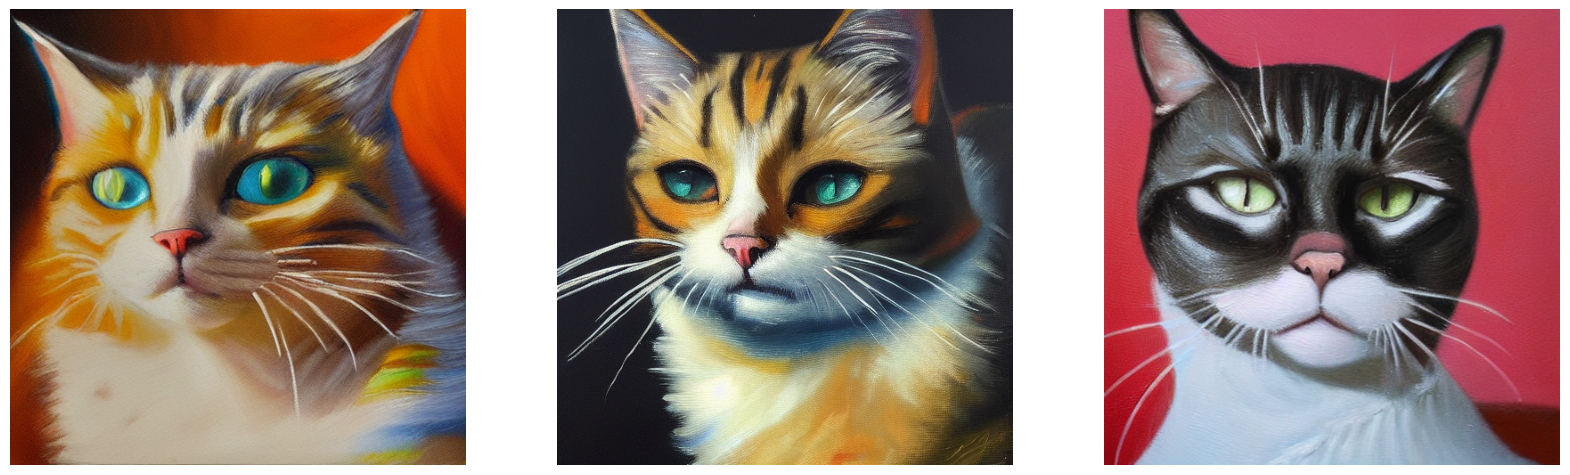

In [ ]:
generated = stable_diffusion.text_to_image(
    f"an oil painting of {placeholder_token}", seed=1337, batch_size=3
)
plot_images(generated)

As you can see, the model still thinks of our token as a cat, as this was the seed token
we used to initialize our custom token.

Now, to get started with training, we can just `compile()` our model like any other
Keras model. Before doing so, we also instantiate a noise scheduler for training and
configure our training parameters such as learning rate and optimizer.

In [ ]:
noise_scheduler = NoiseScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    train_timesteps=1000,
)
trainer = StableDiffusionFineTuner(stable_diffusion, noise_scheduler, name="trainer")
EPOCHS = 50
learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4, decay_steps=train_ds.cardinality() * EPOCHS
)
optimizer = keras.optimizers.Adam(
    weight_decay=0.004, learning_rate=learning_rate, epsilon=1e-8, global_clipnorm=10
)

trainer.compile(
    optimizer=optimizer,
    # We are performing reduction manually in our train step, so none is required here.
    loss=keras.losses.MeanSquaredError(reduction="none"),
)

To monitor training, we can produce a `keras.callbacks.Callback` to produce a few images
every epoch using our custom token.

We create three callbacks with different prompts so that we can see how they progress
over the course of training. We use a fixed seed so that we can easily see the
progression of the learned token.

In [ ]:
class GenerateImages(keras.callbacks.Callback):
    def __init__(self, stable_diffusion, prompt, steps=50, frequency=10, seed=None, **kwargs):
        super().__init__(**kwargs)
        self.stable_diffusion = stable_diffusion
        self.prompt = prompt
        self.seed = seed
        self.frequency = frequency
        self.steps = steps

    def on_epoch_end(self, epoch, logs):
        if epoch % self.frequency == 0:
            images = self.stable_diffusion.text_to_image(
                self.prompt, batch_size=3, num_steps=self.steps, seed=self.seed
            )
            plot_images(
                images,
            )


cbs = [
    GenerateImages(
        stable_diffusion, prompt=f"an oil painting of {placeholder_token}", seed=1337
    ),
    GenerateImages(
        stable_diffusion, prompt=f"gandalf the gray as a {placeholder_token}", seed=1337
    ),
    GenerateImages(
        stable_diffusion,
        prompt=f"two {placeholder_token} getting married, photorealistic, high quality",
        seed=1337,
    ),
]

Now, all that is left to do is to call `model.fit()`!

In [ ]:
trainer.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=cbs,
)

Epoch 1/50
250/250 [==============================] - 802s 3s/step - loss: 0.1495
Epoch 2/50
250/250 [==============================] - 413s 2s/step - loss: 0.1536
Epoch 3/50
250/250 [==============================] - 412s 2s/step - loss: 0.1283
Epoch 4/50
250/250 [==============================] - 412s 2s/step - loss: 0.1771
Epoch 5/50
250/250 [==============================] - 411s 2s/step - loss: 0.1394
Epoch 6/50
250/250 [==============================] - 412s 2s/step - loss: 0.1356
Epoch 7/50
250/250 [==============================] - 411s 2s/step - loss: 0.1489
Epoch 8/50
250/250 [==============================] - 411s 2s/step - loss: 0.1309
Epoch 9/50
 44/250 [====>.........................] - ETA: 5:33 - loss: 0.3075

It's pretty fun to see how the model learns our new token over time. Play around with it
and see how you can tune training parameters and your training dataset to produce the
best images!



## Taking the Fine Tuned Model for a Spin

Now for the really fun part. We've learned a token embedding for our custom token, so
now we can generate images with StableDiffusion the same way we would for any other
token!

Here are some fun example prompts to get you started, with sample outputs from our cat
doll token!

In [ ]:
generated = stable_diffusion.text_to_image(
    f"Gandalf as a {placeholder_token} fantasy art drawn by disney concept artists, "
    "golden colour, high quality, highly detailed, elegant, sharp focus, concept art, "
    "character concepts, digital painting, mystery, adventure",
    batch_size=3,
)
plot_images(generated)

In [ ]:
generated = stable_diffusion.text_to_image(
    f"A masterpiece of a {placeholder_token} crying out to the heavens. "
    f"Behind the {placeholder_token}, an dark, evil shade looms over it - sucking the "
    "life right out of it.",
    batch_size=3,
)
plot_images(generated)

In [ ]:
generated = stable_diffusion.text_to_image(
    f"An evil {placeholder_token}.", batch_size=3
)
plot_images(generated)

In [ ]:
generated = stable_diffusion.text_to_image(
    f"A mysterious {placeholder_token} approaches the great pyramids of egypt.",
    batch_size=3,
)
plot_images(generated)

## Conclusions

Using the Textual Inversion algorithm you can teach StableDiffusion new concepts!

Some possible next steps to follow:

- Try out your own prompts
- Teach the model a style
- Gather a dataset of your favorite pet cat or dog and teach the model about it